In [1]:
import os
import cv2
import glob
import keras
import random
import numpy as np
import tensorflow as tf
from keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.layers import Input,Dense,Conv2D,MaxPooling2D,BatchNormalization,Flatten,Dropout
from sklearn.utils.class_weight import compute_class_weight
from keras.metrics import Precision, Recall


In [2]:
TRAIN_PATH = './fingers/train/*'
TEST_PATH = './fingers/test/*'
FILE_NAME = 'fingers_detection.keras'
MODEL_PATH = 'fingers_detection_model'
KERNEL = (3,3)
CLASSES = 2
IMAGE_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 50

In [ ]:
def load_dataset(path):
    dataset = []
    for img_path in glob.glob(path):
        label = 1 if img_path[-6] == '1' else 0
        img = load_image(img_path)
        dataset.append((label, img))
    return dataset


def load_image(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.uint8)
    img = np.reshape(img, (IMAGE_SIZE, IMAGE_SIZE))
    return img

def show_image(img):
    imgplot = plt.imshow(img, cmap='gray')
    plt.show()

def show_images(dataset, grid_size=5):
    _, axes = plt.subplots(grid_size, grid_size, figsize=(12, 12))
    axes = [y for x in axes for y in x]
    for (i, (label, img)) in enumerate(random.sample(dataset, grid_size**2)):
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(label)
        axes[i].axis('off')

def process_stream_image(img):
    img = cv2.copyMakeBorder(img.copy(), 50, 50, 50, 50, cv2.BORDER_CONSTANT, value=[255, 255, 255])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = process_image(img)
    return img


def process_image(img):
    # Resize image to uniform size
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    # Normalize pixel values to [0, 1]
    img = img.astype(np.float32) / 255.0 # basically img is numpy array (lets say 2x2 with integer values 0[black] - 255[white] ) so we convert each interger into 32-bit floating point number and then divide each float with 255 so each of them becomes in the range (0-1) e.g: 0.47058824, 0.9411765)
    # Add channel dimension for compatibility with models expecting (H, W, 1)
    img = np.reshape(img, (IMAGE_SIZE, IMAGE_SIZE, 1))
    return img

def process_dataset(dataset):
    dataset = [(label, process_image(img)) for (label, img) in dataset]
    return dataset

In [5]:
train_set = load_dataset(TRAIN_PATH)
test_set = load_dataset(TEST_PATH)

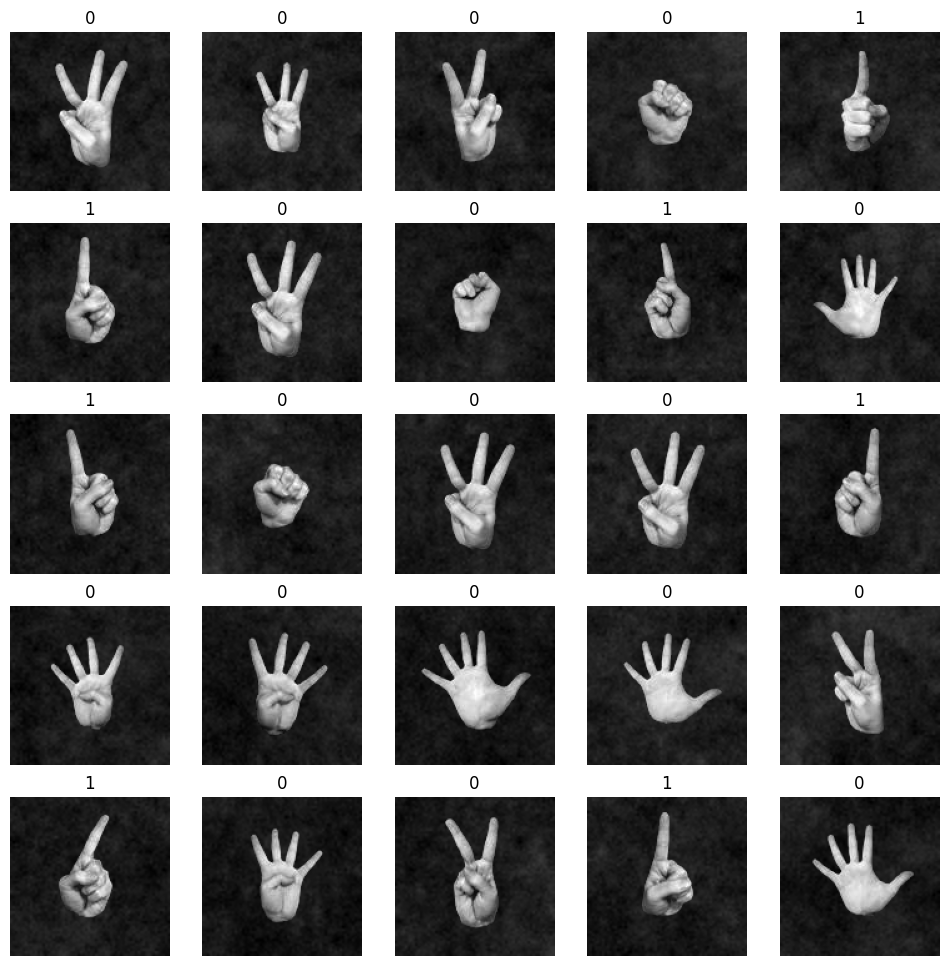

In [6]:
show_images(train_set)

In [7]:
training_set = process_dataset(train_set)
testing_set = process_dataset(test_set)

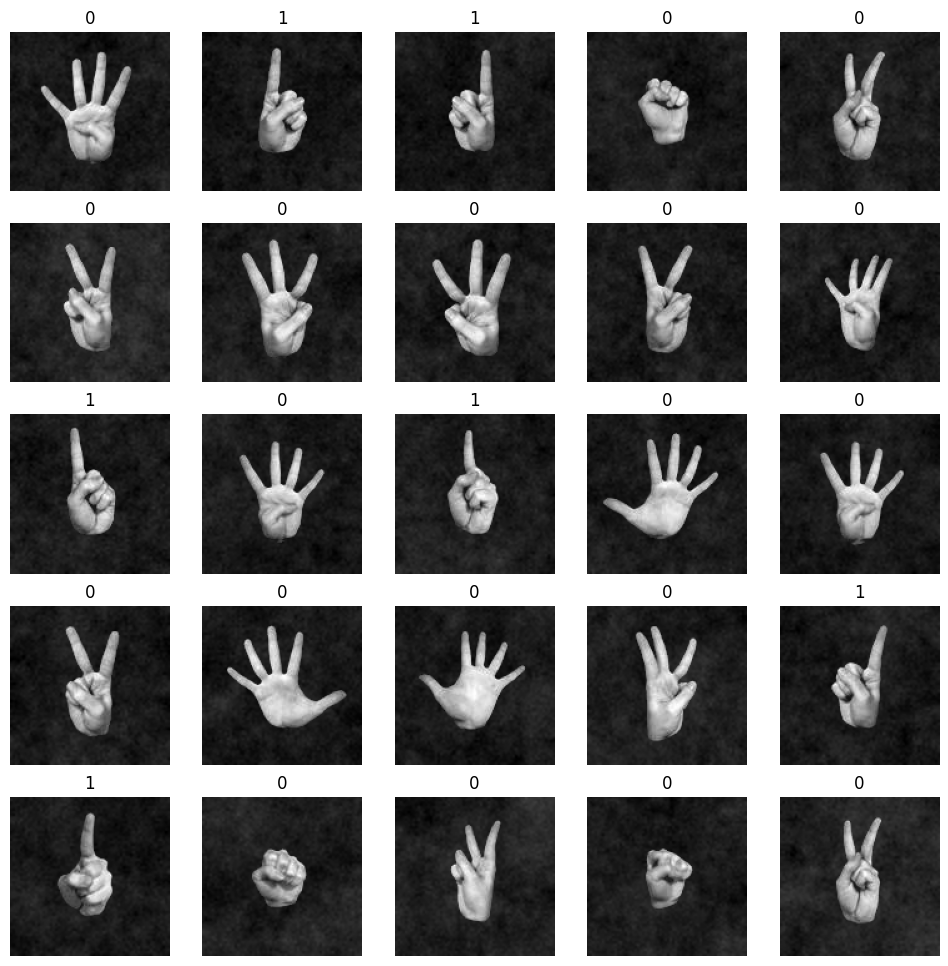

In [ ]:
# basically again showing few images after processing dataset (resizing,normalizing,reshaping etc)
show_images(training_set)  

In [9]:
X_train = np.array([img for (_, img) in training_set])
Y_train = np.array([label for (label, _) in training_set])
X_test = np.array([img for (_, img) in testing_set])
Y_test = np.array([label for (label, _) in testing_set])

In [10]:
# Compute class weights
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(Y_train),
    y=Y_train
)
class_weight_dict = {i: class_weights_array[i] for i in range(len(class_weights_array))}
print("Computed class weights:", class_weight_dict)

Computed class weights: {0: 0.6, 1: 3.0}


In [11]:
print(X_train.shape)
print(Y_train.shape)

(18000, 128, 128, 1)
(18000,)


In [12]:
img_generator = ImageDataGenerator(
    rotation_range=45,
    zoom_range=0.2,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.1,
    horizontal_flip=False,
    fill_mode="nearest"
)



In [14]:
def get_model():
    input_shape=[IMAGE_SIZE, IMAGE_SIZE, 1]
        
    model = keras.models.Sequential([
            Input(input_shape),
            Conv2D(64, KERNEL, strides=(1, 1), activation='relu'),
            MaxPooling2D((2, 2)),
            BatchNormalization(),
            Conv2D(128, KERNEL, strides=(1, 1), activation='relu'),
            MaxPooling2D((2, 2)),
            BatchNormalization(),
            Conv2D(256, KERNEL, strides=(1, 1), activation='relu'),
            MaxPooling2D((2, 2)),
            BatchNormalization(),
            Conv2D(64, KERNEL, strides=(1, 1), activation='relu'),
            MaxPooling2D((2, 2)),
            BatchNormalization(),
            Dropout(0.2),
            Flatten(),
            Dense(1, activation="sigmoid"),
        ])
    model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy", Precision(), Recall()],
)
    return model

In [15]:
checkpoint = ModelCheckpoint(FILE_NAME, monitor='loss', verbose=1, save_best_only=True, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='loss', verbose=1, factor=0.5, patience=1, min_lr=0.0001, mode='min')
earlyStopping = EarlyStopping(monitor='val_loss', verbose=1, min_delta=0, restore_best_weights = True, patience=3, mode='min')
callbacks_list = [checkpoint, earlyStopping, reduce_lr]

model = get_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 63, 63, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 30, 30, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 64)     │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 6, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         2,305 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 521,537 (1.99 MB)

 Trainable params: 520,513 (1.99 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [16]:
# Training the model if the model is not saved
history = model.fit(
        x = img_generator.flow(X_train, Y_train, batch_size=BATCH_SIZE),
        steps_per_epoch= X_train.shape[0] // BATCH_SIZE,
        validation_data= img_generator.flow(X_test, Y_test, batch_size=BATCH_SIZE),
        validation_steps= X_test.shape[0] // BATCH_SIZE,
        epochs= EPOCHS,
        callbacks= callbacks_list,
		class_weight=class_weight_dict
    )

Epoch 1/50


c:\Users\maazk\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


562/562 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8142 - loss: 0.3689 - precision: 0.4828 - recall: 0.8764
Epoch 1: loss improved from inf to 0.26879, saving model to fingers_detection.keras
562/562 ━━━━━━━━━━━━━━━━━━━━ 627s 1s/step - accuracy: 0.8143 - loss: 0.3687 - precision: 0.4829 - recall: 0.8765 - val_accuracy: 0.9531 - val_loss: 0.2037 - val_precision: 0.8039 - val_recall: 0.9516 - learning_rate: 1.0000e-04
Epoch 2/50
  1/562 ━━━━━━━━━━━━━━━━━━━━ 15:40 2s/step - accuracy: 0.9375 - loss: 0.1432 - precision: 0.7500 - recall: 1.0000

c:\Users\maazk\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: loss improved from 0.26879 to 0.14317, saving model to fingers_detection.keras
562/562 ━━━━━━━━━━━━━━━━━━━━ 42s 71ms/step - accuracy: 0.9375 - loss: 0.1432 - precision: 0.7500 - recall: 1.0000 - val_accuracy: 0.9481 - val_loss: 0.1996 - val_precision: 0.8033 - val_recall: 0.9111 - learning_rate: 1.0000e-04
Epoch 3/50
562/562 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9410 - loss: 0.1351 - precision: 0.7528 - recall: 0.9724
Epoch 3: loss improved from 0.14317 to 0.11700, saving model to fingers_detection.keras
562/562 ━━━━━━━━━━━━━━━━━━━━ 623s 1s/step - accuracy: 0.9410 - loss: 0.1351 - precision: 0.7528 - recall: 0.9724 - val_accuracy: 0.9548 - val_loss: 0.1131 - val_precision: 0.7899 - val_recall: 0.9933 - learning_rate: 1.0000e-04
Epoch 4/50
  1/562 ━━━━━━━━━━━━━━━━━━━━ 9:53 1s/step - accuracy: 0.9375 - loss: 0.1253 - precision: 0.7143 - recall: 1.0000
Epoch 4: loss did not improve from 0.11700
562/562 ━━━━━━━━━━━━━━━━━━━━ 40s 69ms/step - accuracy: 0.9375 - loss: 0.1253 

In [17]:
tf.saved_model.save(model, MODEL_PATH)

INFO:tensorflow:Assets written to: fingers_detection_model\assets


INFO:tensorflow:Assets written to: fingers_detection_model\assets


In [18]:
model = load_model("fingers_detection.keras")
results = model.evaluate(X_test, Y_test)
print(f"Loss: {results[0]}, Accuracy: {results[1]}, Precision: {results[2]}, Recall: {results[3]}")


113/113 ━━━━━━━━━━━━━━━━━━━━ 25s 213ms/step - accuracy: 0.9980 - loss: 0.0124 - precision: 0.9878 - recall: 1.0000
Loss: 0.012843375094234943, Accuracy: 0.9975000023841858, Precision: 0.9852216839790344, Recall: 1.0


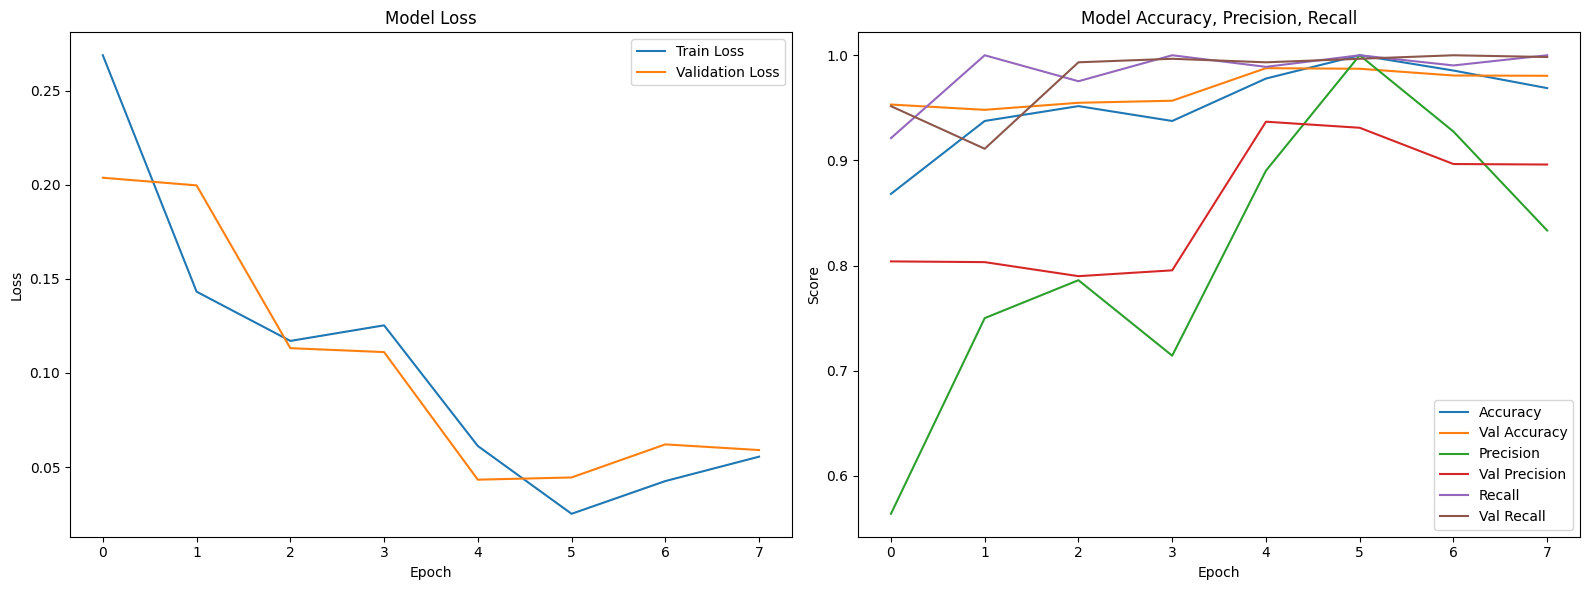

In [ ]:
plt.figure(figsize=(16, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy, Precision, Recall
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.plot(history.history['precision'], label='Precision')
plt.plot(history.history['val_precision'], label='Val Precision')
plt.plot(history.history['recall'], label='Recall')
plt.plot(history.history['val_recall'], label='Val Recall')
plt.title('Model Accuracy, Precision, Recall')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()

plt.tight_layout()
plt.savefig('model_metrices/training_metrics.png')
plt.show()


In [20]:
y_pred = model.predict(X_test)
y_pred_labels = (y_pred > 0.5).astype(int).flatten()
y_true_labels = Y_test.flatten()

print(confusion_matrix(y_true_labels, y_pred_labels))
print(classification_report(y_true_labels, y_pred_labels))


113/113 ━━━━━━━━━━━━━━━━━━━━ 28s 250ms/step
[[2991    9]
 [   0  600]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3000
           1       0.99      1.00      0.99       600

    accuracy                           1.00      3600
   macro avg       0.99      1.00      1.00      3600
weighted avg       1.00      1.00      1.00      3600



In [21]:
class FingerClassifier(object):
    def __init__(self, model_object):
        self.detect = model_object

    def get_classification(self, img):
        img = img.reshape(1, *img.shape)
        img = tf.constant(img, dtype=float)

        # Basic threshold check for presence of hand-like region
        unique, counts = np.unique(img, return_counts=True)
        if len(counts) <= 1 or counts[1] < 1200:
            return -1

        output = self.detect(img)
        predicted = 1 if output.numpy()[0][0] > 0.5 else 0


        # Only return 1 if prediction is class 1 (i.e., one finger)
        if predicted == 1:
            return 1
        else:
            return -1


In [22]:
obj = FingerClassifier(model)